In [1]:
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
from sklearn.datasets import make_gaussian_quantiles
from sklearn import linear_model
from sklearn import metrics
import sklearn.base as skbase
from tqdm.notebook import tqdm

import scipy


# Датасет

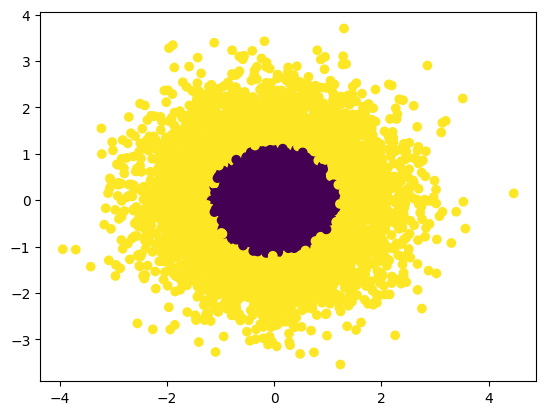

In [2]:
X, y = make_gaussian_quantiles(n_features=2, n_samples=10000, n_classes=2)
X = pd.DataFrame(data=X, columns=['x', 'y'])
y = pd.Series(index=X.index, data=y)
plt.scatter(X['x'], X['y'], c=y)

In [3]:
class FStump(skbase.BaseEstimator):
    def fit(self, X, y):
        splits = []
        models = []
        scores = []
        for name in X.columns:
            x = X[name]
            for thres in np.percentile(x, list(range(101))):
                splits.append((name, thres))
        random.shuffle(splits)
        splits = splits[0:int(len(splits) * 2/3)]
        for name, thres in splits:
            vector = (x < thres).values.reshape(-1, 1).astype(float)
            model = linear_model.LinearRegression().fit(vector, y)
            y_pred = model.predict(vector)
            models.append(model)
            scores.append(metrics.r2_score(y, y_pred))
        res_idx = np.argmax(scores)
        self.name, self.thres = splits[res_idx]
        self.model = models[res_idx]
        return self

    def predict(self, X):
        vector = (X[self.name] < self.thres).values.reshape(-1, 1).astype(float)
        return self.model.predict(vector)

In [4]:
EPS = 1e-3

class LossDesc():
    def loss(self, y_true, y_pred):
        return metrics.log_loss(y_true, y_pred)

    def pseudo_residual(self, y_true, y_pred):
        y_true = np.array(y_true)
        y_pred = self.refine_preds(y_pred)
        return y_true / y_pred - (1 - y_true) / (1 - y_pred)

    def initial(self, y_true):
        return 0.5

    def refine_preds(self, y_pred):
        return np.clip(y_pred, a_min=EPS, a_max=1 - EPS)

LossDesc().pseudo_residual([0, 1], [0.9, 0.9])

array([-10.        ,   1.11111111])

In [5]:
class Booster(skbase.BaseEstimator):
    def __init__(self, estimator, loss_desc, num_steps=100, lr=0.9):
        super().__init__()
        self.estimator = estimator
        self.loss_desc = loss_desc
        self.gammas = []
        self.models = []
        self.num_steps = num_steps
        self.initial = None
        self.lr = lr
        
    def fit(self, X, y):
        self.initial = self.loss_desc.initial(y)
        prev = np.array([self.initial for _ in y])
        for _ in tqdm(range(self.num_steps)):
            ri = self.loss_desc.pseudo_residual(y, prev)
            model = skbase.clone(self.estimator)
            X_eff = X.sample(frac=0.66)
            model.fit(X_eff, ri[X_eff.index])
            
            ri_pred = model.predict(X)
            gamma = scipy.optimize.minimize(
                lambda gamma: self.loss_desc.loss(y, prev + gamma * ri_pred),
                x0=0.1
            ).x[0]
            self.models.append(model)
            self.gammas.append(gamma)
            prev = prev + gamma * ri_pred * self.lr
            prev = self.loss_desc.refine_preds(prev)
            # print(self.loss_desc.loss(y, prev))
            
        return self

    def predict(self, X, step_limit=None):
        res = np.array([self.initial for _ in range(len(X))])
        for step_num, (model, gamma) in enumerate(zip(self.models, self.gammas)):
            if step_limit is not None and step_num >= step_limit:
                return res
            res = res + gamma * model.predict(X) * self.lr
            res = self.loss_desc.refine_preds(res)
        return res

booster = Booster(FStump(), LossDesc())
booster.fit(X, y)
metrics.roc_auc_score(y, booster.predict(X))

  0%|          | 0/100 [00:00<?, ?it/s]

0.99228658

# Analize

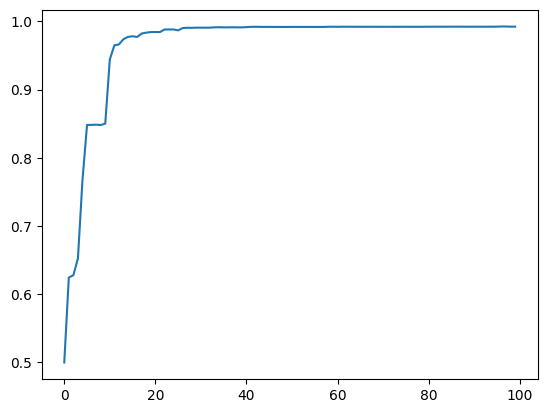

In [6]:
step_roc_auc = [
    metrics.roc_auc_score(y, booster.predict(X, step_limit=limit))
    for limit in range(booster.num_steps)
]
plt.plot(step_roc_auc)

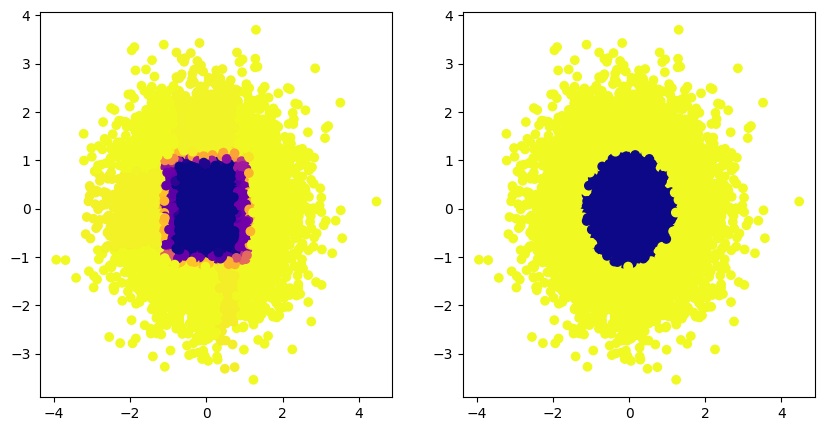

In [7]:
step = None
step_pred = booster.predict(X, step_limit=step)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(X['x'], X['y'], c=step_pred, cmap='plasma')
plt.subplot(1, 2, 2)
plt.scatter(X['x'], X['y'], c=y, cmap='plasma')